### Object Detection using `YOLO`

In this notebook we are going to learn how to use `YOLO` to perform object detection in python

First we need to install required packages to perform this task which is:

In [1]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.4/591.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 23.9 MB/s eta 0:00:00


To make predictions from the `CLI` you run the following command.

In [2]:
!yolo predict model=yolov8n.pt source='https://ultralytics.com/images/bus.jpg'

100% 6.23M/6.23M [00:00<00:00, 75.3MB/s]
Ultralytics YOLOv8.0.109 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients

100% 476k/476k [00:00<00:00, 13.7MB/s]
image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 60.4ms
Speed: 12.4ms preprocess, 60.4ms inference, 36.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


An image named `bus.jpg` will be created in the `runs/detect/predict2` folder and we cab visualize it as follows:

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import os

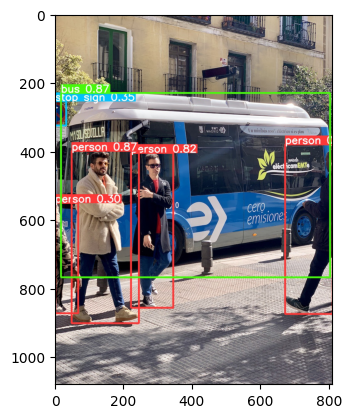

In [4]:
predicted = Image.open(os.path.join('runs/detect/predict', 'bus.jpg'))
plt.imshow(predicted)
plt.show()

### Training

Let's have a look on how we can train our custom object detection model on top of the `YOLO` V8. We are going to use the dataset called `Plastic In River` from (huggingface.co)[https://huggingface.co/datasets/Kili/plastic_in_river] So we will need to download this dataset. If you open the `plastic_in_river/dataset_infos.json` file under `Files and Versions` you will be able to see that these are the dataset classes that we will can train our model to detect:

```py
classes = ["PLASTIC_BAG", "PLASTIC_BOTTLE", "OTHER_PLASTIC_WASTE", "NOT_PLASTIC_WASTE"]
```
Our datset contains a `litter` and an `image`. A litter object looks as follows:

```py
{ "label": [ 2, 2 ], "bbox": [ [ 0.6937950878166246, 0.17073695372684755, 0.017922646728097735, 0.01173880955290596 ], [ 0.5574886429634603, 0.1807987904864813, 0.021695835512960393, 0.01006183675963368 ] ] }
```
Where we have the labels and the bounding box for each label. Let's have a look on how we can create a dataset that we will feed into our `YOLO` model. YOLO expects the bounding box of the image to be:

```py
x_center_n, y_center_n, bbox_w_n, bbox_h_n

-> where n stands for normalised.
```
While in most datasets we get the bounding box in the following formats:
```
x_min, y_min, x_max, y_max
x_1, y_1, x_2, y_2
x, y, w, h
```
Let's say we have the bounding box in the following fomart:

```
x, y, w, h
```
We can convert this to `YOLO` required bonding box as:

```
(x + bbox_w/2)/w, (y + bbox_h/2)/h, bbox_w/w, bbox_h/h
```

The image that we have are already in the format `YOLO` expect them from this dataset, so we acn go ahead and download the dataset.

In [5]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.7 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset

In [7]:
dataset = load_dataset('Kili/plastic_in_river')
dataset

Generating train split:   0%|          | 0/3407 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/425 [00:00<?, ? examples/s]

Dataset plastic_in_river downloaded and prepared to /root/.cache/huggingface/datasets/Kili___plastic_in_river/default/1.3.0/9f50c1fffe85018c95137b17f0e5a271be58507e17e7a3f3a4075f763c20b8de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'litter'],
        num_rows: 3407
    })
    test: Dataset({
        features: ['image', 'litter'],
        num_rows: 427
    })
    validation: Dataset({
        features: ['image', 'litter'],
        num_rows: 425
    })
})

Let's check a single example in the `train` set

In [8]:
dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1280x720 at 0x7F6F6539DBD0>,
 'litter': {'label': [2, 2],
  'bbox': [[0.6937950849533081,
    0.17073695361614227,
    0.017922647297382355,
    0.011738809756934643],
   [0.5574886202812195,
    0.18079878389835358,
    0.021695835515856743,
    0.010061836801469326]]}}

Now that we have our dataset we wantto create a dataset that `YOLO` expects when training an object detection model. So we are going to have the following folder stuctures.

```
📁 dataset
  📁 images
    📁 train
      - 0.png
      - 1.png
      ...
    📁 validation
  📁 labels
    📁 train
    - 0.txt
    - 1.txt
    ...
    📁 validation

```
Where `0.txt` file looks like:

```
1 x_n y_n w_n h_n
0 x_n y_n w_n h_n
0 x_n y_n w_n h_n
...
```

If you don't have anything the file will be empty.


Let's create the folders that we need to store these images and labels.




In [9]:
os.makedirs('datasets/labels/train', exist_ok=True)
os.makedirs('datasets/images/train', exist_ok=True)
os.makedirs('datasets/labels/validation', exist_ok=True)
os.makedirs('datasets/images/validation', exist_ok=True)

Lets create a function called `dump_images_and_labels` that will be able to dump images and labels from their respective splits.

In [10]:
def dump_images_and_labels(data, split):
  data = data[split]
  for i, example in enumerate(data):
    image = example['image']
    labels = example['litter']['label']
    bboxes = example['litter']['bbox']
    targets = list()
    for label, box in zip(labels, bboxes):
      targets.append(f"{label} {' '.join([str(i) for i in box])}")
    
    with open(f'datasets/labels/{split}/{i}.txt', 'w') as writer:
      for target in targets:
        writer.write(target + "\n")
    image.save(f"datasets/images/{split}/{i}.png")

Now we can split our automate the process of creating our `images` and `labels` files using `dump_images_and_labels` function.

In [11]:
dump_images_and_labels(dataset, 'train')
dump_images_and_labels(dataset, 'validation')

Once the process of data preparation is done, we are going to look at training the `YOLO` model that suits our usecase. In their docs they this is their example:

```shell
from ultralytics import YOLO
# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from YAML
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# Train the model
model.train(data='coco128.yaml', epochs=100, imgsz=640)
```

We are going to load the `pytorch` model as their recommendation and we are going to load the `YOLOv8m` which is the medium model, you can check the models that are suported on their [github](https://github.com/ultralytics/ultralytics#models)

In [12]:
from ultralytics import YOLO
model = YOLO('yolov8m.pt')  # load a pretrained model (recommended for training)

100%|██████████| 49.7M/49.7M [00:00<00:00, 200MB/s]


We are then going to create a `yaml` file which called `data.yaml`is required for us to train the model based on our custom dataset and it will look as follows:

```yaml
path: .
train: images/train
val: images/validation
test: #optional

names:
  0: PLASTIC_BAG
  1: PLASTIC_BOTTLE
  2: OTHER_PLASTIC_WASTE
  3: NOT_PLASTIC_WASTE
```

After that we are going to train the model by calling the `train`. Note that the parameters that are passed to the train function can be found in the docummentation. All we need to specify is the `imagesz` which is the `image-size` our width and height of the image.

In [13]:
imgsz = dataset['train'][0]['image'].size
imgsz

(1280, 720)

In [14]:
model.train(
    data='data.yaml', 
    epochs=5, 
    imgsz=imgsz, # (w, h)
    batch=8,
    optimizer="Adam",
    lr0=1e-3
)

Ultralytics YOLOv8.0.109 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=5, patience=50, batch=8, imgsz=(1280, 720), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, wor

### Making predictions

Now that our model has trained we can now use it to make predictions.

In [19]:
best_model_name = 'runs/detect/train/weights/best.pt'
img = dataset['test'][9]['image']
res = model.predict(img)[0]
res


0: 736x1280 2 PLASTIC_BOTTLEs, 79.9ms
Speed: 4.6ms preprocess, 79.9ms inference, 3.6ms postprocess per image at shape (1, 3, 1280, 1280)


ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'PLASTIC_BAG', 1: 'PLASTIC_BOTTLE', 2: 'OTHER_PLASTIC_WASTE', 3: 'NOT_PLASTIC_WASTE'}
orig_img: array([[[124, 116, 127],
        [129, 114, 128],
        [128, 110, 127],
        ...,
        [174, 168, 173],
        [176, 170, 175],
        [177, 171, 176]],

       [[122, 118, 129],
        [126, 113, 127],
        [126, 110, 127],
        ...,
        [175, 169, 174],
        [177, 171, 176],
        [179, 173, 178]],

       [[121, 121, 133],
        [125, 115, 131],
        [123, 111, 129],
        ...,
        [174, 168, 173],
        [177, 171, 176],
        [179, 173, 178]],

       ...,

       [[143, 156, 154],
        [136, 149, 147],
        [132, 145, 143],
        ...,
        [149, 155, 150],
        [150, 156, 151],
        [150, 156, 151]],

       [[141, 152, 150],
        [141, 152, 150],
        [

Drawing bounding box on the image and converting it from `BGR` to `RGB`

In [20]:
res = res.plot(line_width=1)
# bgr to rgb
res = res[:, :, ::-1]

Plotting the predictions

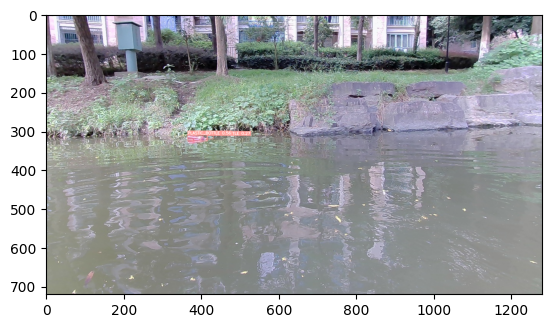

In [21]:
res = Image.fromarray(res)
plt.imshow(res)
plt.show()

### Refs

1. [github.com](https://github.com/ultralytics/ultralytics)
2. [docs](https://docs.ultralytics.com/)
3. [huggingface.co](https://huggingface.co/datasets)
4. [datasets](https://pypi.org/project/datasets/)